Air Quality Index Prediction

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
data = pd.read_csv('station_day.csv')


In [21]:
data.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,NaN,NaN
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate


# Data Cleaning

In [22]:
# Data Cleaning
def clean_data(data):
    """Cleans the dataset by handling missing values and invalid data."""
    # Convert 'Date' to datetime format
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

    # Handle missing values in numeric columns by filling with median
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    data[numeric_cols] = data[numeric_cols].apply(lambda col: col.fillna(col.median()))

    # Drop rows with invalid dates
    data.dropna(subset=['Date'], inplace=True)

    # Reset index after cleaning
    data.reset_index(drop=True, inplace=True)

    return data

data = clean_data(data)

In [23]:
data.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,132.0,NaN
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate


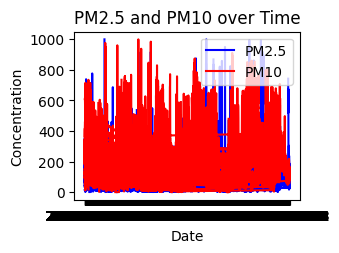

In [44]:
# Time Series Plots for PM2.5, PM10, NO, NO2, O3, CO
plt.subplot(2, 2, 1)
plt.plot(data['Date'], data['PM2.5'], label='PM2.5', color='blue')
plt.plot(data['Date'], data['PM10'], label='PM10', color='red')
plt.title('PM2.5 and PM10 over Time')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()


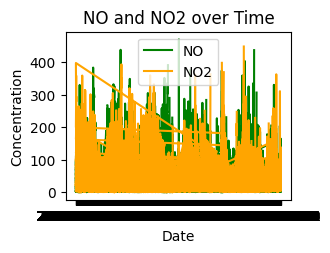

In [45]:
plt.subplot(2, 2, 2)
plt.plot(data['Date'], data['NO'], label='NO', color='green')
plt.plot(data['Date'], data['NO2'], label='NO2', color='orange')
plt.title('NO and NO2 over Time')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()

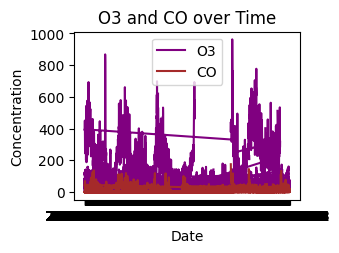

In [46]:
plt.subplot(2, 2, 3)
plt.plot(data['Date'], data['O3'], label='O3', color='purple')
plt.plot(data['Date'], data['CO'], label='CO', color='brown')
plt.title('O3 and CO over Time')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()

In [47]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

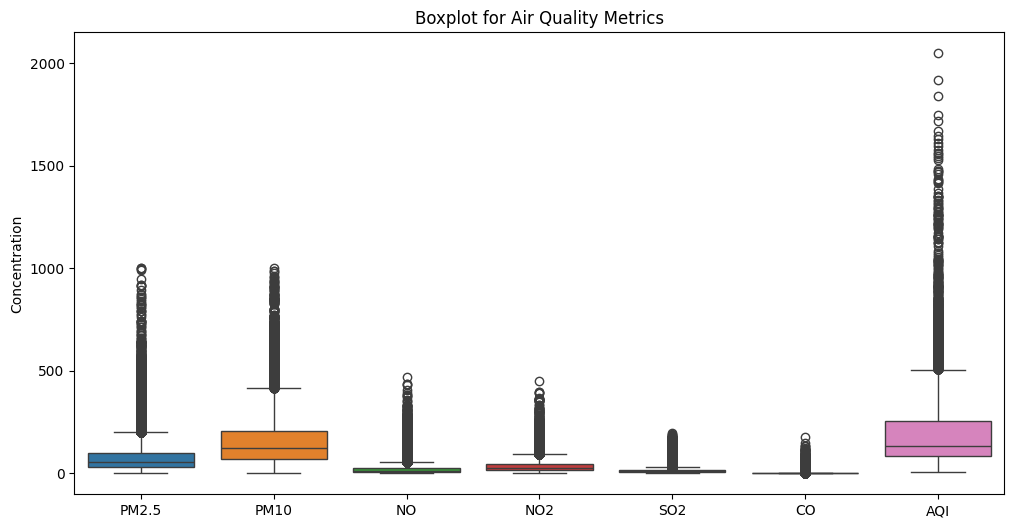

In [48]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['PM2.5', 'PM10', 'NO', 'NO2', 'SO2', 'CO', 'AQI']])
plt.title('Boxplot for Air Quality Metrics')
plt.ylabel('Concentration')
plt.show()

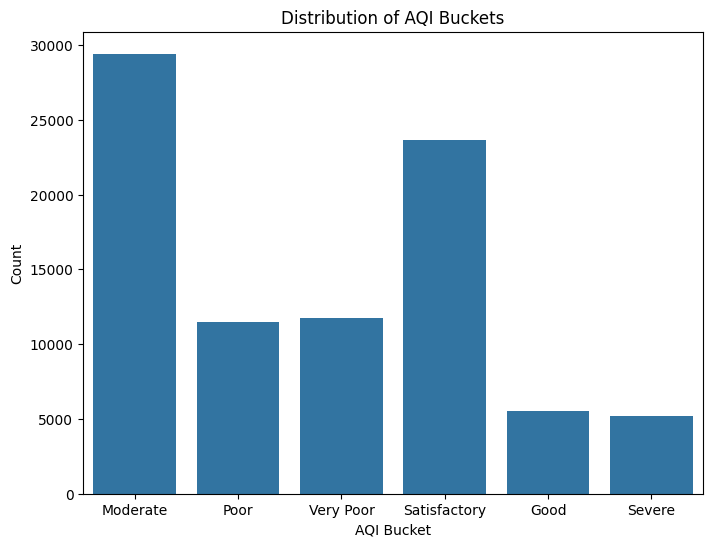

In [49]:
# AQI distribution (if you want to see how AQI is distributed in terms of buckets)
plt.figure(figsize=(8, 6))
sns.countplot(x='AQI_Bucket', data=data)
plt.title('Distribution of AQI Buckets')
plt.xlabel('AQI Bucket')
plt.ylabel('Count')
plt.show()

# Exploratory Data Analysis (EDA)


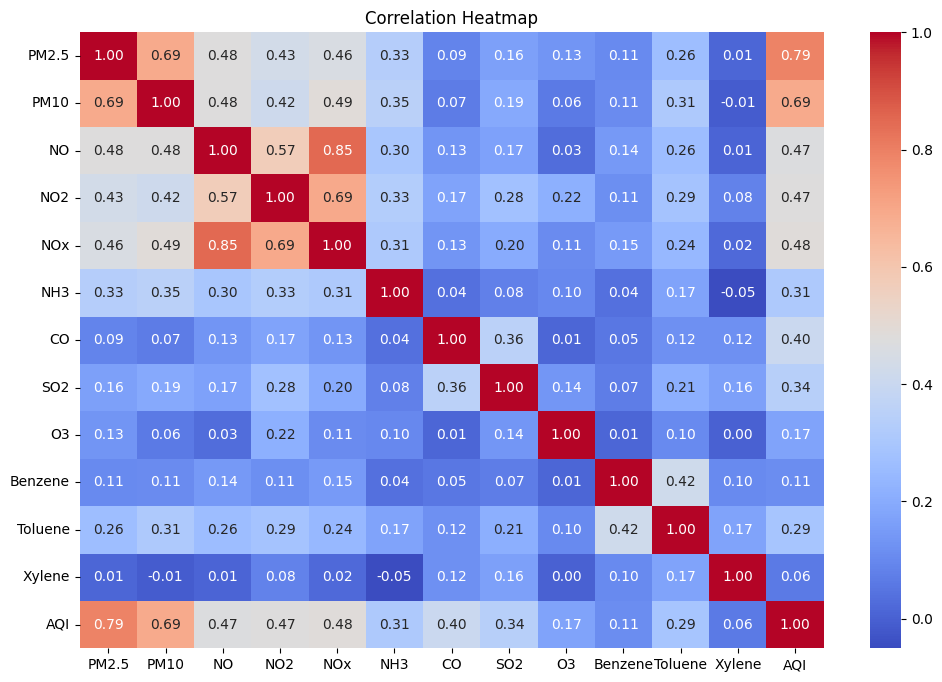

In [25]:
# Fix for correlation heatmap to handle non-numeric columns
def plot_correlation_heatmap(data):
    # Select only numeric columns for correlation
    numeric_data = data.select_dtypes(include=['float64', 'int64'])
    plt.figure(figsize=(12, 8))
    corr = numeric_data.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

plot_correlation_heatmap(data)


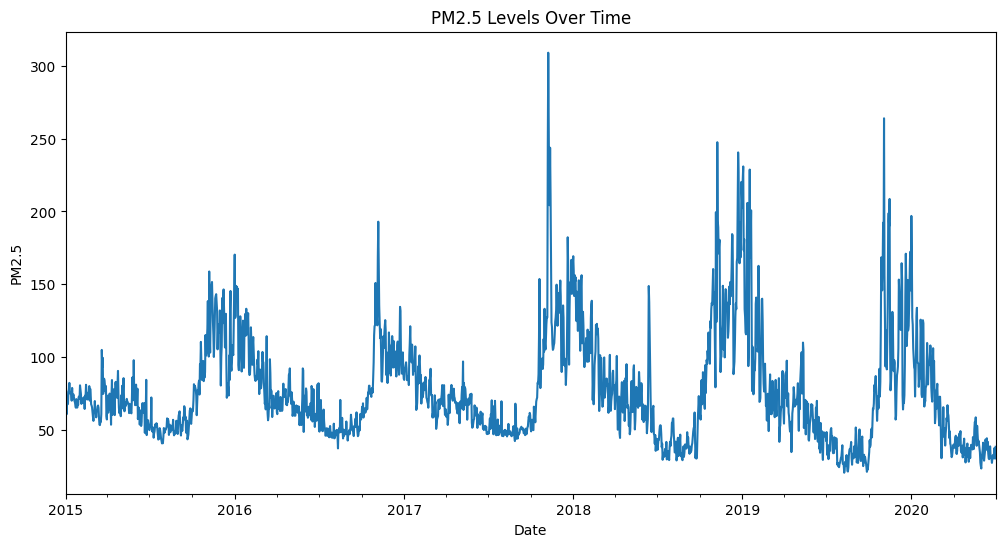

In [26]:

def plot_time_series(data, column, title):
    """Plots a time series for the specified column."""
    plt.figure(figsize=(12, 6))
    data.groupby('Date')[column].mean().plot()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.show()

plot_time_series(data, 'PM2.5', 'PM2.5 Levels Over Time')


# Prepare Data for Modeling


In [27]:
# Prepare Data for Modeling
def prepare_data(data):
    """Prepares features and target variables for training and testing."""
    features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']
    target = 'AQI'

    # Drop rows with missing values in features or target
    data = data.dropna(subset=features + [target])

    X = data[features]
    y = data[target]
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = prepare_data(data)


# Train a Random Forest Model

In [28]:
def train_model(X_train, y_train):
    """Trains a Random Forest Regressor model."""
    model = RandomForestRegressor(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    return model

model = train_model(X_train, y_train)

# Evaluate the Model


In [29]:
def evaluate_model(model, X_test, y_test):
    """Evaluates the model and prints key metrics."""
    y_pred = model.predict(X_test)
    print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
    print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
    print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R-Squared (R2):", r2_score(y_test, y_pred))

evaluate_model(model, X_test, y_test)

Mean Absolute Error (MAE): 19.718558699972455
Mean Squared Error (MSE): 1592.8258327408942
Root Mean Squared Error (RMSE): 39.91022215850087
R-Squared (R2): 0.8898505560361007


# Feature Importance

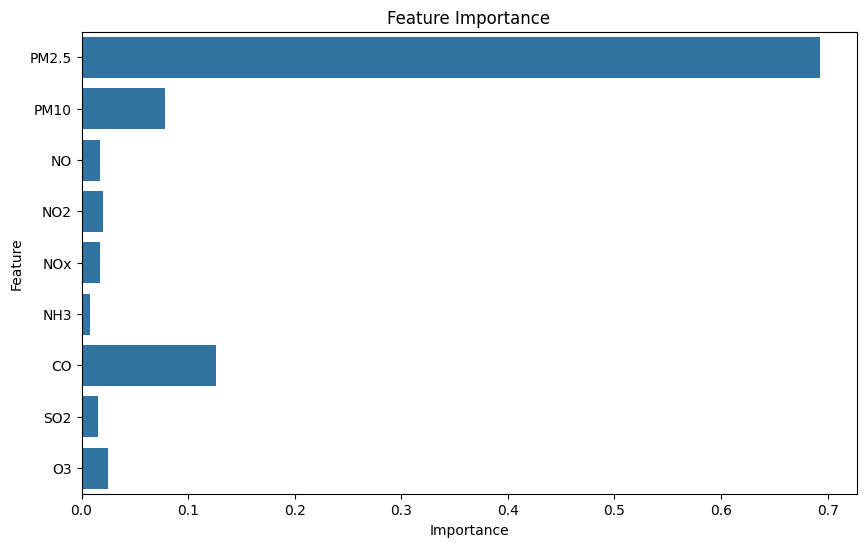

In [30]:
# Feature Importance
def plot_feature_importance(model, feature_names):
    """Plots feature importance for the trained model."""
    importance = model.feature_importances_
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance, y=feature_names)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

plot_feature_importance(model, X_train.columns)

# Save the Cleaned Data and Model

In [34]:
def save_outputs(data, model, data_path='cleaned_aqi_data.csv', model_path='aqi_prediction_model.pkl'):
    """Saves the cleaned dataset and trained model."""
    data.to_csv(data_path, index=False)
    joblib.dump(model, model_path)
    print("Cleaned data saved to:", data_path)
    print("Model saved to:", model_path)

save_outputs(data, model)

Cleaned data saved to: cleaned_aqi_data.csv
Model saved to: aqi_prediction_model.pkl


In [35]:
print("Pipeline complete: Data cleaning, visualization, modeling, and evaluation.")

Pipeline complete: Data cleaning, visualization, modeling, and evaluation.


In [50]:
pip install gradio

   ---------------------------------------- 0.0/57.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/57.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/57.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/57.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/57.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/57.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/57.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/57.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/57.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/57.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/57.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/57.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/57.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/57.2 MB ? eta -:--:--
   -----------------

In [53]:
import gradio as gr
import joblib
import pandas as pd

# Load the trained model
model = joblib.load('aqi_prediction_model.pkl')

# Define a function to make predictions using the trained model
def predict_aqi(PM2_5, PM10, NO, NO2, NOx, NH3, CO, SO2, O3):
    """Predict AQI based on the input features using the trained model."""
    # Create a DataFrame with the input features
    input_data = pd.DataFrame([[PM2_5, PM10, NO, NO2, NOx, NH3, CO, SO2, O3]],
                              columns=['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3'])
    
    # Make the prediction using the model
    predicted_aqi = model.predict(input_data)[0]
    return predicted_aqi

# Define the Gradio interface with the new syntax
inputs = [
    gr.Number(label='PM2.5'),
    gr.Number(label='PM10'),
    gr.Number(label='NO'),
    gr.Number(label='NO2'),
    gr.Number(label='NOx'),
    gr.Number(label='NH3'),
    gr.Number(label='CO'),
    gr.Number(label='SO2'),
    gr.Number(label='O3')
]

outputs = gr.Textbox(label="Predicted AQI")

# Create the interface
gr.Interface(fn=predict_aqi, inputs=inputs, outputs=outputs, title="AQI Prediction", 
             description="Enter the values of air pollutants to predict AQI").launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
